# Project 3 S-box nonlinearity optimization using evolutionary methods
## Łukasz Andryszewski
### 151930
## Adam Korba
### 151962

In [1]:
import numpy as np
from sympy import fwht
import os
from itertools import combinations
import random
from deap import base, creator, tools, algorithms
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

np.random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)

# 1. Represent S-boxes as permutations of 0…255 and implement checks
We represent S-boxes as numpy arrays of 256 integers.
We implement a check to ensure the S-box is a valid permutation.

In [2]:
def byte2bit(_in: np.array):
    assert _in.dtype == np.uint8
    return np.unpackbits(_in)

def bit2byte(_in: np.array):
    assert _in.dtype == np.uint8
    return np.packbits(_in)

def random_input():
    return byte2bit(np.random.randint(0,256,dtype=np.uint8))

def random_sbox():
    return np.random.permutation(256).astype(np.uint8)

def get_bool_func(sbox: np.array, j=0):
    assert 0 <= j <= 7
    bit = 1 << j # take jth bit
    bool_func_arr = np.bitwise_and(sbox,bit) # take the significant bit of each sbox
    bool_func_arr = np.right_shift(bool_func_arr,j) # right shift to get boolean array
    return bool_func_arr

In [3]:
np.right_shift(2,1)

np.int64(1)

In [4]:
bit2byte(byte2bit(np.array([23,12],dtype=np.uint8)))

array([23, 12], dtype=uint8)

In [5]:
a = random_sbox()
a

array([228,   6,  79, 206, 117, 185, 242, 167,   9,  30, 180, 222, 230,
       217, 136,  68, 199,  15,  96,  24, 235,  19, 120, 152,  33, 124,
       253, 208,  10, 164, 184,  97, 148, 190, 223,  25,  86,  18,  75,
       137, 196, 176, 239, 181,  45,  66,  16,  67, 215, 201, 177,  38,
       143,  84,  55, 220, 104, 139, 127,  60, 101, 172, 245, 126, 225,
       144, 108, 178,  73, 114, 158,  69, 141, 109, 115, 246, 113, 243,
        90,  29, 170,  82, 111,   5,  56, 132, 154, 162,  65, 186,  85,
       219, 237,  31,  12,  35,  28,  42, 112,  22, 125,  93, 173, 251,
        51, 240,  95, 146, 204,  76,  41, 119, 155,  78, 150,  26, 247,
       168, 118, 193, 140,   0,   2,  77,  46, 100, 205, 159, 183, 254,
        98,  36,  61, 200, 142,  11, 250, 224,  27, 231,   4, 122,  32,
       147, 182, 138,  62, 135, 128, 232, 194,  70, 197,  64,  44, 165,
       156,  40, 123, 153,  23, 192, 249,  81,  39, 244,  47,  94, 195,
       161,  43, 145, 175,   3, 105,  53, 133, 233, 198, 238,  4

In [6]:
get_bool_func(np.arange(256,dtype=np.uint8),0)

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1], dtype=uint8)

# 2. Implement metrics for a given S-box
We implement the following metrics:
- Minimum component nonlinearity
- Differential Uniformity (DU)
- SAC summary
- BIC summary
- Number of fixed points and opposite fixed points
- Algebraic degree

We then compute these metrics for the S-box used by AES for comparison.

In [7]:
# https://gist.github.com/bonsaiviking/5571001
AES_SBOX = np.array([0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
            0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
            0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
            0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
            0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
            0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
            0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
            0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
            0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
            0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
            0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
            0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
            0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
            0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
            0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
            0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16],dtype=np.uint8)

In [21]:
def boolean_components(sbox):
    B = np.zeros((8, 256), dtype=np.int8)
    for j in range(8):
        B[j] = (sbox >> j) & 1
    return B

def nonlinearity_bool(bool_func):
    wave_vector = (-2*bool_func)+1 # equivalent to np.power(-1, bool_func) for 0 and 1 (0->+1, 1->-1)
    W = fwht(wave_vector) #can't get it faster
    #M = np.max(np.abs(transformed).astype(np.int32))
    return (1<<7) - (np.max(np.abs(W))>>1)

# optimization goal
def nonlinearity(sbox):
    B = boolean_components(sbox)
    min_nl = 128
    for mask in np.arange(1,256,dtype=np.uint8):
        a = ((mask>>np.arange(8))&1).astype(np.int8)
        combined = (a @ B) & 1
        # combined = np.bitwise_xor.reduce(
        #     np.unpackbits(np.bitwise_and(mask,sbox)[:,np.newaxis],axis=1),
        #     axis=1)
        nl = nonlinearity_bool(combined)
        if nl < min_nl:
            min_nl = nl
            if min_nl == 0:
                break

    return int(min_nl)

In [22]:
def differential_uniformity(sbox):
    n = 256
    max_du = 0
    
    for delta_x in range(1, n):
        x = np.arange(n, dtype=np.uint8)
        x_xor_delta = x ^ delta_x
        delta_y = sbox[x] ^ sbox[x_xor_delta]
        
        counts = np.bincount(delta_y, minlength=n)
        current_max = np.max(counts)
        
        if current_max > max_du:
            max_du = current_max
            
    return max_du

def sac_metrics(sbox):
    n = 256
    sac_matrix = np.zeros((8, 8))
    
    for i in range(8):
        input_flip_mask = 1 << i
        
        x = np.arange(n, dtype=np.uint8)
        x_flipped = x ^ input_flip_mask
        
        y = sbox[x]
        y_flipped = sbox[x_flipped]
        
        diff = y ^ y_flipped
        
        for j in range(8):
            output_bit_mask = 1 << j
            changes = (diff & output_bit_mask) >> j
            prob = np.sum(changes) / n
            sac_matrix[i, j] = prob
            
    return sac_matrix

def bic_metrics(sbox):
    n = 256
    correlations = []
    
    for i in range(8):
        input_flip_mask = 1 << i
        x = np.arange(n, dtype=np.uint8)
        x_flipped = x ^ input_flip_mask
        
        y = sbox[x]
        y_flipped = sbox[x_flipped]
        diff = y ^ y_flipped
        
        change_vectors = []
        for j in range(8):
            mask = 1 << j
            vec = (diff & mask) >> j
            change_vectors.append(vec)
            
        for j in range(8):
            for k in range(j + 1, 8):
                v1 = change_vectors[j]
                v2 = change_vectors[k]
                if np.std(v1) == 0 or np.std(v2) == 0:
                    corr = 0
                else:
                    corr = np.corrcoef(v1, v2)[0, 1]
                correlations.append(abs(corr))
                
    return np.mean(correlations)

def count_fixed_points(sbox):
    x = np.arange(256, dtype=np.uint8)

    fixed_pts = np.sum(sbox == x)
    opposite_fixed_pts = np.sum(sbox == (x ^ 0xFF))
    
    return fixed_pts, opposite_fixed_pts

def algebraic_degree(sbox):
    max_degree = 0
    n = 8
    N = 256
    
    for j in range(8):
        func = get_bool_func(sbox, j)
        
        anf = np.copy(func)
        for i in range(n):
            step = 1 << i
            for k in range(0, N, 2 * step):
                for l in range(step):
                    anf[k + l + step] ^= anf[k + l]
        
        current_max_deg = 0
        for idx, val in enumerate(anf):
            if val == 1:
                hw = bin(idx).count('1')
                if hw > current_max_deg:
                    current_max_deg = hw
        
        if current_max_deg > max_degree:
            max_degree = current_max_deg
            
    return max_degree

In [23]:
test_sbox = random_sbox()
print(f"Nonlinearity: {nonlinearity(test_sbox)}")
print(f"Differential Uniformity: {differential_uniformity(test_sbox)}")
fp, ofp = count_fixed_points(test_sbox)
print(f"Fixed Points: {fp}, Opposite Fixed Points: {ofp}")
print(f"Algebraic Degree: {algebraic_degree(test_sbox)}")
sac = sac_metrics(test_sbox)
print(f"SAC Matrix Mean: {np.mean(sac)}")
bic = bic_metrics(test_sbox)
print(f"BIC Score: {bic}")

Nonlinearity: 92
Differential Uniformity: 10
Fixed Points: 1, Opposite Fixed Points: 3
Algebraic Degree: 7
SAC Matrix Mean: 0.50927734375
BIC Score: 0.06851485033898862


In [24]:
test_sbox = AES_SBOX
print(f"Nonlinearity: {nonlinearity(test_sbox)}")
print(f"Differential Uniformity: {differential_uniformity(test_sbox)}")
fp, ofp = count_fixed_points(test_sbox)
print(f"Fixed Points: {fp}, Opposite Fixed Points: {ofp}")
print(f"Algebraic Degree: {algebraic_degree(test_sbox)}")
sac = sac_metrics(test_sbox)
print(f"SAC Matrix Mean: {np.mean(sac)}")
bic = bic_metrics(test_sbox)
print(f"BIC Score: {bic}")

Nonlinearity: 112
Differential Uniformity: 4
Fixed Points: 0, Opposite Fixed Points: 0
Algebraic Degree: 7
SAC Matrix Mean: 0.5048828125
BIC Score: 0.0521532615898042


# 3. Baseline study
We generate a sample of random S-boxes (e.g., 300) and measure the metrics.
We plot/describe the distribution of: minimum NL, DU, degree, SAC deviations, fixed points.

Generating and evaluating 100 random S-boxes...


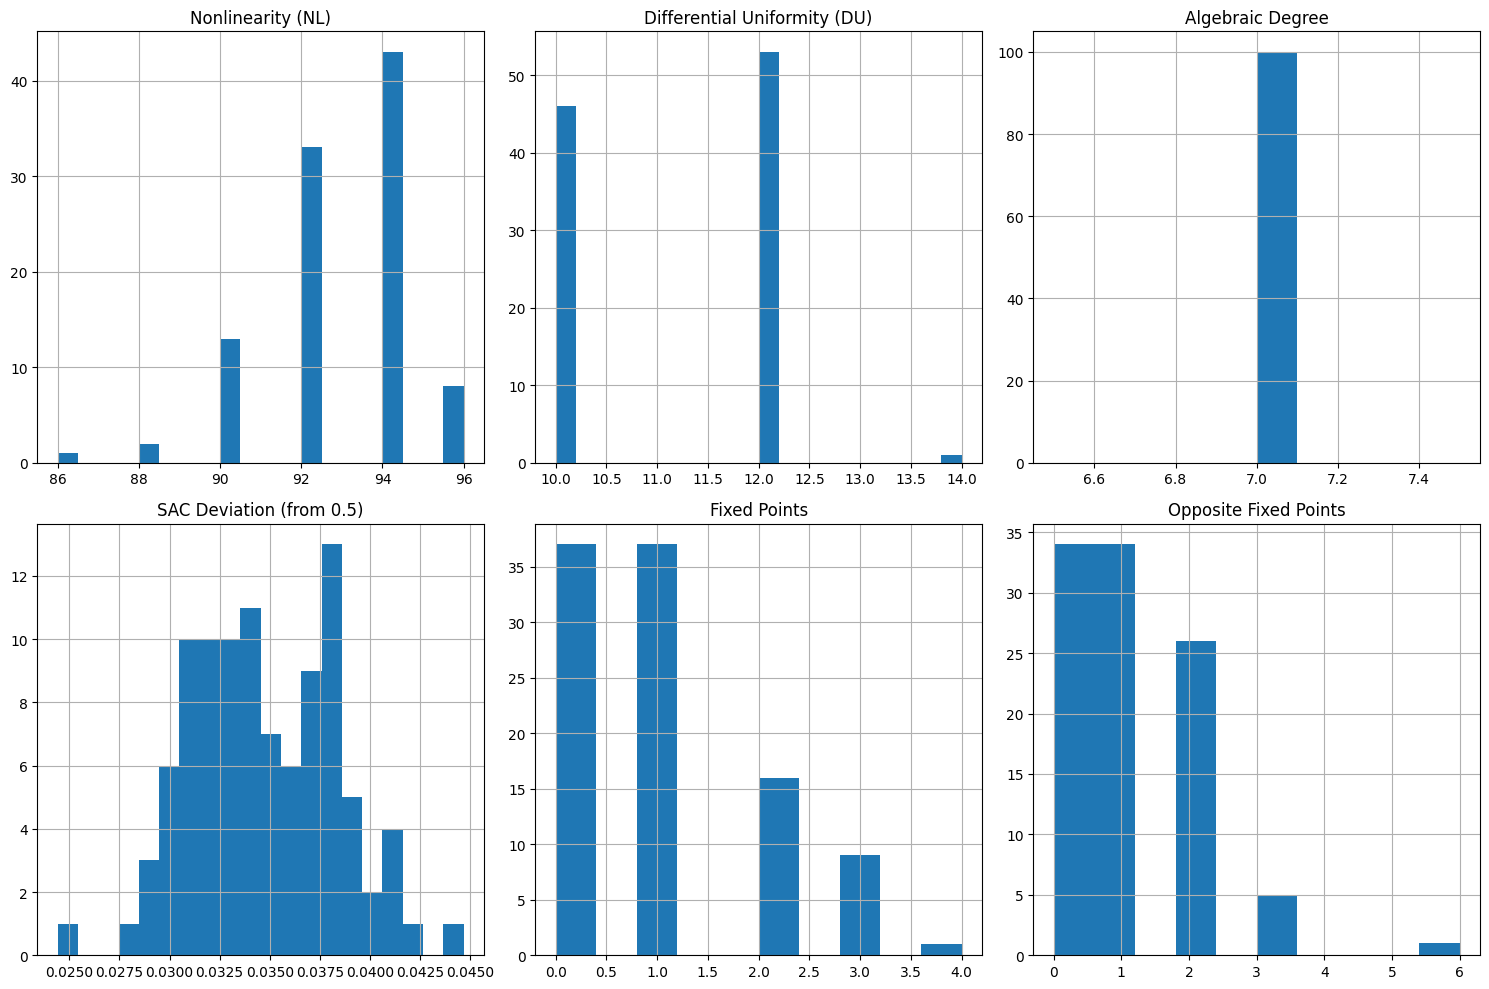

Baseline Statistics:
               NL          DU  Degree     SAC_Dev  Fixed_Points  \
count  100.000000  100.000000   100.0  100.000000    100.000000   
mean    92.780000   11.100000     7.0    0.034749      1.000000   
std      1.904699    1.039619     0.0    0.003684      0.994937   
min     86.000000   10.000000     7.0    0.024414      0.000000   
25%     92.000000   10.000000     7.0    0.031982      0.000000   
50%     94.000000   12.000000     7.0    0.034302      1.000000   
75%     94.000000   12.000000     7.0    0.037598      2.000000   
max     96.000000   14.000000     7.0    0.044678      4.000000   

       Opposite_Fixed_Points  
count             100.000000  
mean                1.070000  
std                 1.027451  
min                 0.000000  
25%                 0.000000  
50%                 1.000000  
75%                 2.000000  
max                 6.000000  


In [25]:
# Generate 300 random S-boxes
baseline_samples = 100
baseline_data = []

print(f"Generating and evaluating {baseline_samples} random S-boxes...")

for _ in range(baseline_samples):
    sbox = random_sbox()
    nl = nonlinearity(sbox)
    du = differential_uniformity(sbox) 
    deg = algebraic_degree(sbox)
    sac = sac_metrics(sbox)
    sac_dev = np.mean(np.abs(sac - 0.5)) # SAC deviation from 0.5
    fp, ofp = count_fixed_points(sbox)
    
    baseline_data.append({
        'NL': nl,
        'DU': du,
        'Degree': deg,
        'SAC_Dev': sac_dev,
        'Fixed_Points': fp,
        'Opposite_Fixed_Points': ofp
    })

baseline_df = pd.DataFrame(baseline_data)

# Plot distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
baseline_df['NL'].astype('int32').hist(ax=axes[0, 0], bins=20)
axes[0, 0].set_title('Nonlinearity (NL)')

baseline_df['DU'].hist(ax=axes[0, 1], bins=20)
axes[0, 1].set_title('Differential Uniformity (DU)')

baseline_df['Degree'].hist(ax=axes[0, 2], bins=10)
axes[0, 2].set_title('Algebraic Degree')

baseline_df['SAC_Dev'].hist(ax=axes[1, 0], bins=20)
axes[1, 0].set_title('SAC Deviation (from 0.5)')

baseline_df['Fixed_Points'].hist(ax=axes[1, 1], bins=10)
axes[1, 1].set_title('Fixed Points')

baseline_df['Opposite_Fixed_Points'].hist(ax=axes[1, 2], bins=10)
axes[1, 2].set_title('Opposite Fixed Points')

plt.tight_layout()
plt.show()

print("Baseline Statistics:")
print(baseline_df.describe())

# 4. Define a fitness function that combines the metrics
We define a fitness function that:
- Prioritises minimum nonlinearity (target 112)
- Penalises high DU (especially > 4)
- Rewards higher algebraic degree
- Penalises fixed and opposite fixed points
- Penalises deviations of SAC from 0.5

In [26]:
def swap(individual, i_j):
    i,j = i_j
    temp = individual[i]
    individual[i] = individual[j]
    individual[j] = temp
    return individual

def mutate(individual):
    n = len(individual)
    i = np.random.randint(n)
    j = (np.random.randint(n) + i - 1)%n
    swap(individual,(i,j))
    return individual,

def evaluate(individual):
    # Convert individual to numpy array for metric calculations
    sbox = np.array(individual, dtype=np.uint8)
    
    # Calculate metrics
    nl = nonlinearity(sbox)
    du = differential_uniformity(sbox)
    fp, ofp = count_fixed_points(sbox)
    
    # Store metrics in individual for logging
    individual.nl = nl
    individual.du = du
    individual.fp = fp
    individual.ofp = ofp
    
    # Fitness function design:
    # 1. Maximize Nonlinearity (Target 112)
    # 2. Minimize Differential Uniformity (Target <= 4)
    # 3. Minimize Fixed Points (Target 0)
    
    # Weighted sum approach
    # We give high weight to NL to prioritize it.
    # We subtract DU and FP to penalize them.
    
    fitness = (nl * 10) - du - (fp + ofp)
    
    return fitness,

# 5. Choose a search method
We choose an Evolutionary Algorithm (EA).
- Representation: Permutation of 0...255 (list of integers).
- Variation operators:
    - Mutation: Swap two elements.
    - Crossover: Uniform Partially Matched Crossover (UPMX).
- Selection strategy: Tournament selection (size 3).

In [27]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, random_sbox)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxUniformPartialyMatched, indpb=0.4)
toolbox.register("mutate", mutate)
toolbox.register("select", tools.selTournament, tournsize=3)

population = toolbox.population(n=30)
hof = tools.HallOfFame(1)

# Use MultiStatistics to track multiple metrics
stats_fit = tools.Statistics(key=lambda ind: ind.fitness.values)
stats_nl = tools.Statistics(key=lambda ind: ind.nl)
stats_du = tools.Statistics(key=lambda ind: ind.du)
stats_fp = tools.Statistics(key=lambda ind: ind.fp)
stats_ofp = tools.Statistics(key=lambda ind: ind.ofp)

stats = tools.MultiStatistics(fitness=stats_fit, nl=stats_nl, du=stats_du, fp=stats_fp, ofp=stats_ofp)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)
stats.register("std", np.std)

# 6. Run experiments
We run the EA starting from random S-boxes for a fixed evaluation budget.
We track the best-so-far metrics.
We also compare against baselines (Random Search, Hill Climbing).
## Evolutionary Algorithm

In [28]:
ea_final_pop, ea_log = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=50, stats=stats, halloffame=hof, verbose=True)

   	      	                      du                     	                   fitness                    	                           fp                           	                      nl                      	                          ofp                           
   	      	---------------------------------------------	----------------------------------------------	--------------------------------------------------------	----------------------------------------------	--------------------------------------------------------
gen	nevals	avg    	gen	max	min	nevals	std  	avg    	gen	max	min	nevals	std   	avg     	gen	max	min	nevals	std     	avg    	gen	max	min	nevals	std   	avg     	gen	max	min	nevals	std     
0  	30    	11.5333	0  	14 	10 	30    	1.335	915.967	0  	948	867	30    	20.942	0.866667	0  	3  	0  	30    	0.763035	92.9333	0  	96 	88 	30    	2.1124	0.966667	0  	3  	0  	30    	0.795124
1  	20    	11.2   	1  	14 	10 	20    	1.22202	925.6  	1  	947	903	20    	12.1123	0.766667	1  	3  	

## 6.1 NSGA-II Execution
We also run the Multi-Objective Evolutionary Algorithm (NSGA-II) to optimize for multiple objectives simultaneously.

In [29]:
# NSGA-II Setup
# Weights: (Maximize NL, Minimize DU, Minimize FP+OFP)
creator.create("FitnessMulti", base.Fitness, weights=(1.0, -1.0, -1.0))
creator.create("IndividualMulti", list, fitness=creator.FitnessMulti)

toolbox_nsga = base.Toolbox()
toolbox_nsga.register("individual", tools.initIterate, creator.IndividualMulti, random_sbox)
toolbox_nsga.register("population", tools.initRepeat, list, toolbox_nsga.individual)

def evaluate_multi(individual):
    sbox = np.array(individual, dtype=np.uint8)
    nl = nonlinearity(sbox)
    du = differential_uniformity(sbox)
    fp, ofp = count_fixed_points(sbox)
    
    # Store metrics for logging
    individual.nl = nl
    individual.du = du
    individual.fp = fp
    individual.ofp = ofp
    
    return float(nl), float(du), float(fp + ofp)

toolbox_nsga.register("evaluate", evaluate_multi)
toolbox_nsga.register("mate", tools.cxUniformPartialyMatched, indpb=0.4)
toolbox_nsga.register("mutate", mutate)
toolbox_nsga.register("select", tools.selNSGA2)

# Statistics
stats_nsga = tools.MultiStatistics(
    nl=tools.Statistics(key=lambda ind: ind.nl),
    du=tools.Statistics(key=lambda ind: ind.du),
    fp=tools.Statistics(key=lambda ind: ind.fp)
)
stats_nsga.register("avg", np.mean)
stats_nsga.register("min", np.min)
stats_nsga.register("max", np.max)

# Run NSGA-II
pop_nsga = toolbox_nsga.population(n=30)
hof_nsga = tools.ParetoFront()

print("Running NSGA-II...")
pop_nsga, log_nsga = algorithms.eaMuPlusLambda(
    pop_nsga, toolbox_nsga, mu=50, lambda_=50, 
    cxpb=0.5, mutpb=0.2, ngen=50, 
    stats=stats_nsga, halloffame=hof_nsga, verbose=True
)

Running NSGA-II...
   	      	                  du                  	                      fp                      	                  nl                  
   	      	--------------------------------------	----------------------------------------------	--------------------------------------
gen	nevals	avg 	gen	max	min	nevals	avg     	gen	max	min	nevals	avg    	gen	max	min	nevals
0  	30    	11.6	0  	14 	10 	30    	0.933333	0  	3  	0  	30    	91.8667	0  	96 	88 	30    
1  	34    	11.16	1  	14 	10 	34    	0.98    	1  	3  	0  	34    	92.96  	1  	96 	90 	34    
2  	38    	10.84	2  	14 	10 	38    	0.4     	2  	2  	0  	38    	93.04  	2  	96 	90 	38    
3  	35    	10.8 	3  	14 	10 	35    	0.24    	3  	1  	0  	35    	93.52  	3  	96 	90 	35    
4  	36    	10.6 	4  	14 	10 	36    	0.28    	4  	1  	0  	36    	93.96  	4  	96 	92 	36    
5  	31    	10.44	5  	14 	10 	31    	0.16    	5  	1  	0  	31    	93.72  	5  	96 	92 	31    
6  	39    	10.6 	6  	14 	10 	39    	0.12    	6  	1  	0  	39    	94.16  	6 

## Hill climbing (local search)

In [30]:
def localSearch(individual, toolbox, iter_limit=None, stats=None, halloffame=None, verbose=True):
    population = [individual]
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    gen = 1
    while True:
        improvement = False 
        nevals = 0
        for move in toolbox.neighbors(individual):
            new_individual = toolbox.clone(individual)
            new_individual = toolbox.apply_move(new_individual, move)
            fitness = toolbox.evaluate(new_individual)
            nevals += 1
            new_individual.fitness.values = fitness
            if fitness[0] > individual.fitness.values[0]:
                improvement = True
                break
            if iter_limit is not None and nevals >= iter_limit: # 256 choose 2 is around 32k, which would cause the algorithm to run for like half an hour
                break
        
        if improvement:
            individual = new_individual

        if halloffame is not None:
            halloffame.update([individual])
        
        record = stats.compile([individual]) if stats else {}
        logbook.record(gen=gen, nevals=nevals, **record)
        if verbose:
            print(logbook.stream)
        gen += 1
        
        if not improvement:
            break

    return individual, logbook

In [31]:
def neighbours(*_):
    pairs = list(combinations(range(256),2))
    random.shuffle(pairs)
    return pairs

toolbox.register("neighbors", neighbours)
toolbox.register("apply_move", swap)

ITER_LIMIT = 1000
final_ind, ls_log = localSearch(toolbox.individual(), toolbox, iter_limit=ITER_LIMIT, stats=stats, verbose=True)

   	      	                     du                    	                  fitness                  	                     fp                    	                     nl                    	                    ofp                    
   	      	-------------------------------------------	-------------------------------------------	-------------------------------------------	-------------------------------------------	-------------------------------------------
gen	nevals	avg	gen	max	min	nevals	std	avg	gen	max	min	nevals	std	avg	gen	max	min	nevals	std	avg	gen	max	min	nevals	std	avg	gen	max	min	nevals	std
0  	1     	12 	0  	12 	12 	1     	0  	886	0  	886	886	1     	0  	1  	0  	1  	1  	1     	0  	90 	0  	90 	90 	1     	0  	1  	0  	1  	1  	1     	0  
1  	1     	12 	1  	12 	12 	1     	0  	906	1  	906	906	1     	0  	1  	1  	1  	1  	1     	0  	92 	1  	92 	92 	1     	0  	1  	1  	1  	1  	1     	0  
2  	11    	10 	2  	10 	10 	11    	0  	908	2  	908	908	11    	0  	1  	2  	1  	1  	11    	0  	92 	2  	

## Random search

In [32]:
def random_search(samples, toolbox, stats=None, halloffame=None, verbose=True):
    population = toolbox.population(samples)
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    return population, logbook

In [33]:
evaluated_sample, rs_log = random_search(ITER_LIMIT,toolbox,stats)

   	      	                       du                      	                    fitness                    	                       fp                      	                       nl                      	                      ofp                      
   	      	-----------------------------------------------	-----------------------------------------------	-----------------------------------------------	-----------------------------------------------	-----------------------------------------------
gen	nevals	avg   	gen	max	min	nevals	std    	avg    	gen	max	min	nevals	std    	avg	gen	max	min	nevals	std    	avg 	gen	max	min	nevals	std    	avg  	gen	max	min	nevals	std    
0  	1000  	11.348	0  	18 	10 	1000  	1.23568	912.601	0  	969	825	1000  	22.5051	1  	0  	6  	0  	1000  	1.02176	92.6	0  	98 	84 	1000  	2.23607	1.051	0  	6  	0  	1000  	1.02391


# 7. Analyse results
We show convergence plots and present the best S-box found.
We compare the results to the baseline distributions.

In [34]:
def get_metrics(ind, name="Method"):
    # Convert to numpy array if it's not already
    sbox = np.array(ind, dtype=np.uint8)
    
    nl = nonlinearity(sbox)
    du = differential_uniformity(sbox)
    fp, ofp = count_fixed_points(sbox)
    deg = algebraic_degree(sbox)
    sac = sac_metrics(sbox)
    sac_mean = np.mean(sac)
    bic = bic_metrics(sbox)
    
    return {
        "Method": name,
        "Nonlinearity": nl,
        "Diff. Uniformity": du,
        "Fixed Points": fp,
        "Opp. Fixed Points": ofp,
        "Alg. Degree": deg,
        "SAC Mean": sac_mean,
        "BIC Score": bic
    }


In [35]:
def plot_log(log):
    # Check if we have chapters (MultiStatistics)
    if hasattr(log, "chapters") and len(log.chapters) > 0:
        chapters = [key for key in log.chapters]
        fig, axes = plt.subplots(len(chapters), 1, figsize=(10, 3*len(chapters)), sharex=True)
        if len(chapters) == 1:
            axes = [axes]
            
        # Try to get evaluations count, fallback to generation index
        if "nevals" in log[0]:
            evals = np.cumsum(log.select("nevals"))
            x_label = "Evaluations"
        else:
            evals = range(len(log))
            x_label = "Generation"
        
        for i, chapter in enumerate(chapters):
            ax = axes[i]
            # Access the chapter data (list of dicts)
            chapter_log = log.chapters[chapter]
            
            avg_ = [d['avg'] for d in chapter_log]
            min_ = [d['min'] for d in chapter_log]
            max_ = [d['max'] for d in chapter_log]
            
            # Handle tuple values (e.g. fitness)
            if isinstance(avg_[0], (tuple, np.ndarray)) and np.size(avg_[0]) == 1:
                avg_ = [np.item(x) for x in avg_]
                min_ = [np.item(x) for x in min_]
                max_ = [np.item(x) for x in max_]

            ax.plot(evals, avg_, label="avg")
            ax.plot(evals, max_, label="max")
            ax.plot(evals, min_, label="min")
            
            # Optional: Fill between if std is available and scalar
            if 'std' in chapter_log[0]:
                std_ = [d['std'] for d in chapter_log]
                if isinstance(std_[0], (tuple, np.ndarray)) and np.size(std_[0]) == 1:
                    std_ = [np.item(x) for x in std_]
                
                # Ensure all are numeric lists
                try:
                    avg_np = np.array(avg_)
                    std_np = np.array(std_)
                    min_np = np.array(min_)
                    max_np = np.array(max_)
                    ax.fill_between(evals, 
                                    np.clip(avg_np - std_np, a_min=min_np, a_max=None), 
                                    np.clip(avg_np + std_np, a_min=None, a_max=max_np), 
                                    alpha=0.2)
                except:
                    pass # Skip fill_between if data types are incompatible

            ax.set_ylabel(chapter)
            ax.legend()
            ax.grid(True)
            
        axes[-1].set_xlabel(x_label)
        plt.tight_layout()
        return fig
    else:
        # Fallback for simple statistics
        min_ = log.select("min")
        max_ = log.select("max")
        avg_ = log.select("avg")
        std_ = log.select("std")
        evals = np.cumsum(log.select("nevals"))
        plt.plot(evals, avg_, label="avg")
        plt.plot(evals, max_, label="max")
        plt.plot(evals, min_, label="min")
        plt.fill_between(evals, np.clip(np.array(avg_)-np.array(std_),min=min_), np.clip(np.array(avg_)+np.array(std_),max=max_), alpha=0.2)
        plt.legend()
        plt.xlabel("Evaluations")
        plt.ylabel("Fitness")
        return plt.gcf()

## Results of the Evolutionary Algorithm

In [36]:
# Best S-box from EA
best_ea_ind = hof[0]
ea_metrics = get_metrics(best_ea_ind, "Evolutionary Algo")

print("Best S-box metrics (EA):")
for k, v in ea_metrics.items():
    print(f"{k}: {v}")

Best S-box metrics (EA):
Method: Evolutionary Algo
Nonlinearity: 98
Diff. Uniformity: 10
Fixed Points: 0
Opp. Fixed Points: 0
Alg. Degree: 7
SAC Mean: 0.500732421875
BIC Score: 0.07496446400768722


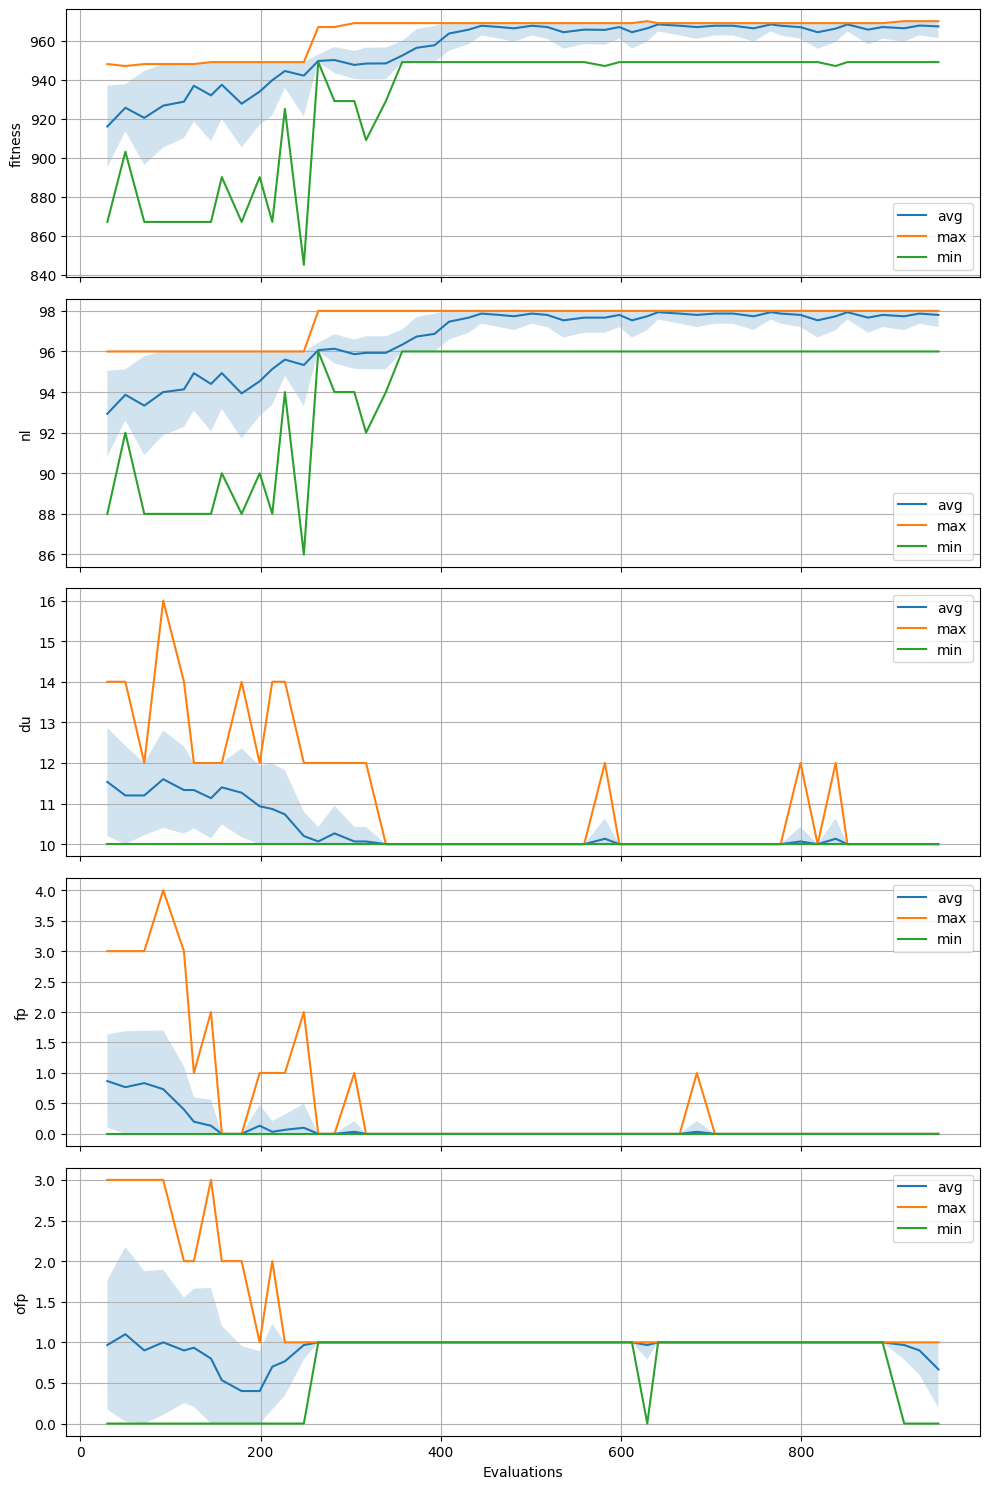

In [37]:
plot_log(ea_log)
plt.show()

## Results of the Hill Climbing

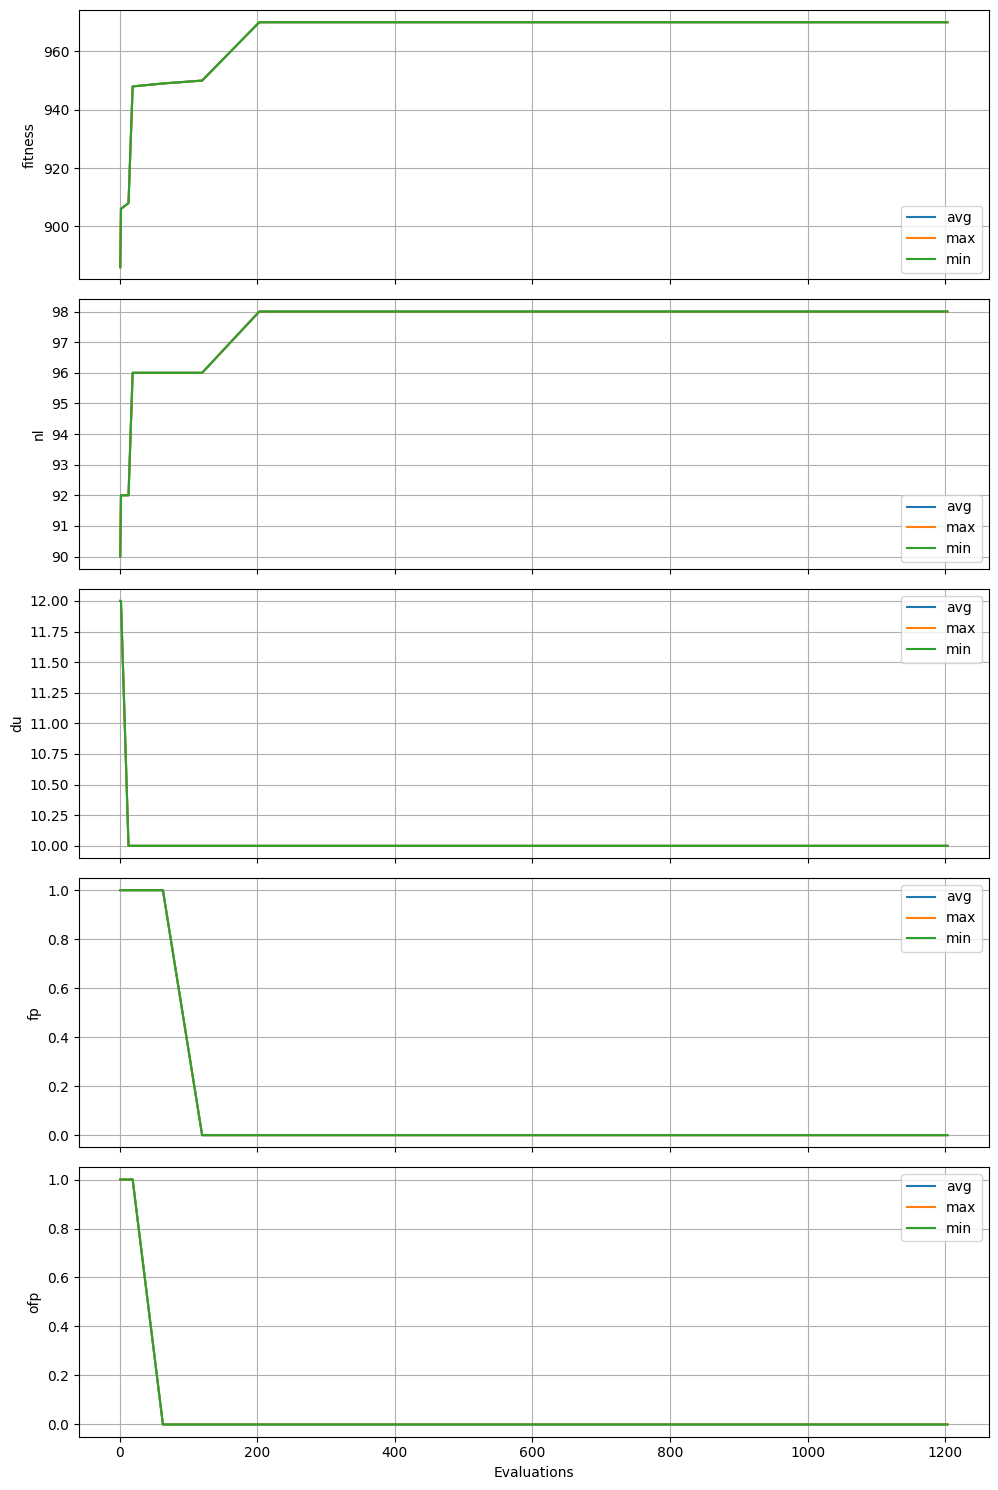

In [38]:
plot_log(ls_log)
plt.show()

In [39]:
# Best S-box from Local Search
ls_metrics = get_metrics(final_ind, "Local Search")

print("Best S-box metrics (Local Search):")
for k, v in ls_metrics.items():
    print(f"{k}: {v}")

Best S-box metrics (Local Search):
Method: Local Search
Nonlinearity: 98
Diff. Uniformity: 10
Fixed Points: 0
Opp. Fixed Points: 0
Alg. Degree: 7
SAC Mean: 0.4990234375
BIC Score: 0.07075306299535908


## Results of the random search

In [40]:
best_rs_ind = tools.selBest(evaluated_sample, 1)[0]
rs_metrics = get_metrics(best_rs_ind, "Random Search")

print("Best S-box metrics (Random Search):")
for k, v in rs_metrics.items():
    print(f"{k}: {v}")


Best S-box metrics (Random Search):
Method: Random Search
Nonlinearity: 98
Diff. Uniformity: 10
Fixed Points: 1
Opp. Fixed Points: 0
Alg. Degree: 7
SAC Mean: 0.510986328125
BIC Score: 0.0675616827572197


## 7.1 NSGA-II Analysis
We analyze the Pareto Front found by NSGA-II and compare the best solution with other methods.

In [41]:
# Analyze Pareto Front
print(f"Number of individuals in Pareto Front: {len(hof_nsga)}")

print("\nPareto Front Solutions:")
nsga_best_ind = None
best_nl = -1

for i, ind in enumerate(hof_nsga):
    metrics = get_metrics(ind, f"NSGA-II Solution {i+1}")
    print(f"Sol {i+1}: NL={metrics['Nonlinearity']}, DU={metrics['Diff. Uniformity']}, FP={metrics['Fixed Points']}")
    
    # Pick the one with best NL for comparison table
    if metrics['Nonlinearity'] > best_nl:
        best_nl = metrics['Nonlinearity']
        nsga_best_ind = ind
    elif metrics['Nonlinearity'] == best_nl:
        # Break ties with DU (lower is better)
        if metrics['Diff. Uniformity'] < differential_uniformity(np.array(nsga_best_ind, dtype=np.uint8)):
            nsga_best_ind = ind


Number of individuals in Pareto Front: 146

Pareto Front Solutions:
Sol 1: NL=98, DU=10, FP=0
Sol 2: NL=98, DU=10, FP=0
Sol 3: NL=98, DU=10, FP=0
Sol 4: NL=98, DU=10, FP=0
Sol 5: NL=98, DU=10, FP=0
Sol 6: NL=98, DU=10, FP=0
Sol 7: NL=98, DU=10, FP=0
Sol 8: NL=98, DU=10, FP=0
Sol 9: NL=98, DU=10, FP=0
Sol 10: NL=98, DU=10, FP=0
Sol 11: NL=98, DU=10, FP=0
Sol 12: NL=98, DU=10, FP=0
Sol 13: NL=98, DU=10, FP=0
Sol 14: NL=98, DU=10, FP=0
Sol 15: NL=98, DU=10, FP=0
Sol 16: NL=98, DU=10, FP=0
Sol 17: NL=98, DU=10, FP=0
Sol 18: NL=98, DU=10, FP=0
Sol 19: NL=98, DU=10, FP=0
Sol 20: NL=98, DU=10, FP=0
Sol 21: NL=98, DU=10, FP=0
Sol 22: NL=98, DU=10, FP=0
Sol 23: NL=98, DU=10, FP=0
Sol 24: NL=98, DU=10, FP=0
Sol 25: NL=98, DU=10, FP=0
Sol 26: NL=98, DU=10, FP=0
Sol 27: NL=98, DU=10, FP=0
Sol 28: NL=98, DU=10, FP=0
Sol 29: NL=98, DU=10, FP=0
Sol 30: NL=98, DU=10, FP=0
Sol 31: NL=98, DU=10, FP=0
Sol 32: NL=98, DU=10, FP=0
Sol 33: NL=98, DU=10, FP=0
Sol 34: NL=98, DU=10, FP=0
Sol 35: NL=98, DU=10, F

In [43]:
nsga_metrics = get_metrics(nsga_best_ind, "NSGA-II")

# 8. Project Report

## Problem Description
The objective of this project was to use Artificial Intelligence and heuristic search methods to find "good" 8x8 S-boxes. An S-box (Substitution-box) is a fundamental component of symmetric key algorithms like AES, providing the necessary confusion. A "good" S-box must satisfy several cryptographic criteria to resist known attacks. The search space is the set of all permutations of 256 elements ($256!$), which is astronomically large, making exhaustive search impossible.

## Definitions of Metrics
*   **Nonlinearity (NL)**: The minimum Hamming distance between the component Boolean functions of the S-box and the set of all affine functions. High nonlinearity protects against linear cryptanalysis. The theoretical maximum for an 8x8 S-box is 112.
*   **Differential Uniformity (DU)**: The maximum probability of a specific output difference occurring for a given input difference. Low DU protects against differential cryptanalysis. Ideally, DU should be 4 or 6 (for random permutations it is often higher).
*   **Strict Avalanche Criterion (SAC)**: Ensures that flipping one input bit changes each output bit with a probability of 0.5.
*   **Bit Independence Criterion (BIC)**: Measures the independence of output bits when an input bit is flipped.
*   **Fixed Points**: Inputs $x$ such that $S(x) = x$. These should be avoided to prevent attacks that exploit them.
*   **Algebraic Degree**: The degree of the polynomial representation of the S-box. High degree prevents higher-order differential attacks.

## Fitness Design and Search Method
We employed two main evolutionary approaches:
1.  **Single-Objective Evolutionary Algorithm (EA)**:
    *   **Fitness Function**: A weighted sum designed to prioritize Nonlinearity.
        $$ Fitness = 10 \cdot NL - DU - (FixedPoints + OppositeFixedPoints) $$
    *   **Representation**: Permutation of integers $0 \dots 255$.
    *   **Operators**:
        *   *Mutation*: Swap mutation (swapping two random elements).
        *   *Crossover*: Uniform Partially Matched Crossover (UPMX) to preserve permutation validity.
        *   *Selection*: Tournament selection.

2.  **Multi-Objective Optimization (NSGA-II)**:
    *   **Objectives**: Simultaneously maximize NL, minimize DU, and minimize Fixed Points. This allows exploring the trade-offs between these conflicting metrics.

We compared these against two baselines: **Random Search** (generating random permutations) and **Local Search** (Hill Climbing).

## Results: Baseline vs. AI Methods


In [54]:
aes_results = get_metrics(AES_SBOX,"AES S-box")
results_df = pd.DataFrame([ea_metrics, nsga_metrics, ls_metrics, rs_metrics, aes_results])
cols = ["Method", "Nonlinearity", "Diff. Uniformity", "Fixed Points", "Opp. Fixed Points", "Alg. Degree", "SAC Mean", "BIC Score"]
results_df = results_df[cols]
results_df_transposed = results_df.set_index('Method').T
display(results_df_transposed)

Method,Evolutionary Algo,NSGA-II,Local Search,Random Search,AES S-box
Nonlinearity,98.000000,98.000000,98.000000,98.000000,112.000000
Diff. Uniformity,10.000000,10.000000,10.000000,10.000000,4.000000
Fixed Points,0.000000,0.000000,0.000000,1.000000,0.000000
Opp. Fixed Points,0.000000,0.000000,0.000000,0.000000,0.000000
Alg. Degree,7.000000,7.000000,7.000000,7.000000,7.000000
SAC Mean,0.500732,0.504639,0.499023,0.510986,0.504883
BIC Score,0.074964,0.068847,0.070753,0.067562,0.052153


## Discussion

### Trade-offs
In our experiments, we did not observe a significant negative trade-off between Nonlinearity and Differential Uniformity. As the Evolutionary Algorithm improved the Nonlinearity, the Differential Uniformity tended to improve (decrease) or stay stable, rather than worsen. This suggests that for S-boxes initialized randomly, we are far from the theoretical Pareto frontier where strict trade-offs between these cryptographic properties typically manifest. Both metrics could be optimized simultaneously without conflict in this search regime.

### Difficulties
*   **Plateaus**: The fitness landscape for Nonlinearity seems to have large plateaus. Many changes to an S-box do not immediately affect the minimum nonlinearity (which is determined by the worst-case component), making gradient-based or simple local search methods inefficient.
*   **Theoretical Limits**: Reaching the theoretical maximum NL of 112 is extremely difficult for heuristic methods without using algebraic construction techniques (like inversion in finite fields). Most heuristic searches plateau around 98, which is low.

### Future Work
*   **Cost Functions**: Implementing more sophisticated cost functions, such as using the nonlinearity of *all* component functions rather than just the minimum, could provide a smoother gradient for the search.
*   **Hybrid Approaches**: Combining EA with specialized local search operators (Memetic Algorithms) that target specific properties (like Walsh spectrum manipulation) could yield better results.
*   **Algebraic Initialization**: Instead of starting from random permutations, starting from algebraically constructed S-boxes (e.g., variations of the inverse function) and using AI to fine-tune secondary properties (like SAC/BIC) might be more effective.